## Work
1. 請改變 reduce_lr 的 patience 和 factor 並比較不同設定下，對訓練/驗證集的影響
2. 請將 optimizer 換成 Adam、RMSprop 搭配 reduce_lr 並比較訓練結果

In [1]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import BatchNormalization

"""
建立神經網路，並加入 BN layer
"""
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [7]:
LEARNING_RATE = 1e-3
EPOCHS = 15 # IF you feel too run to finish, try to make it smaller
BATCH_SIZE = 1024 

In [8]:
# 載入 Callbacks
from keras.callbacks import ReduceLROnPlateau

optimizer_set = [keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=0.95),
                 keras.optimizers.Adam(lr=LEARNING_RATE),
                 keras.optimizers.RMSprop(lr=LEARNING_RATE)]

"""Code Here
建立實驗的比較組合
"""
reduce_lr_factor = [0.2,0.5,0.8]
redice_lr_patient = [5,10]

In [10]:
import itertools
results = {}
for i, (optim, reduce_factor, reduce_patient) in enumerate(itertools.product(optimizer_set, reduce_lr_factor, redice_lr_patient)):
    print("Numbers of exp: %i, reduce_factor: %.2f, reduce_patient: %i" % (i, reduce_factor, reduce_patient))
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optim)
    
    """Code Here
    設定 reduce learning rate 的 callback function
    """
    reduce_lr = ReduceLROnPlateau(factor=reduce_factor, 
                              min_lr=1e-12, 
                              monitor='val_loss', 
                              patience=reduce_patient, 
                              verbose=1)
    
    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True,
              callbacks=[reduce_lr]
             )

    # Collect results
    exp_name_tag = ("exp-%s" % (i))
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["accuracy"],
                             'valid-acc': model.history.history["val_accuracy"]}

Numbers of exp: 0, reduce_factor: 0.20, reduce_patient: 5
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
b

Train on 50000 samples, validate on 10000 samples
Epoch 1/15
50000/50000 [==============================] - 54s 1ms/step - loss: 2.2093 - accuracy: 0.2682 - val_loss: 2.1291 - val_accuracy: 0.1946
Epoch 2/15
50000/50000 [==============================] - 46s 929us/step - loss: 1.7399 - accuracy: 0.3969 - val_loss: 1.9837 - val_accuracy: 0.2874
Epoch 3/15
50000/50000 [==============================] - 46s 912us/step - loss: 1.6207 - accuracy: 0.4355 - val_loss: 1.8315 - val_accuracy: 0.3557
Epoch 4/15
50000/50000 [==============================] - 45s 905us/step - loss: 1.5490 - accuracy: 0.4579 - val_loss: 1.7241 - val_accuracy: 0.4057
Epoch 5/15
50000/50000 [==============================] - 45s 903us/step - loss: 1.4941 - accuracy: 0.4791 - val_loss: 1.6427 - val_accuracy: 0.4244
Epoch 6/15
50000/50000 [==============================] - 47s 950us/step - loss: 1.4518 - accuracy: 0.4922 - val_loss: 1.5820 - val_accuracy: 0.4455
Epoch 7/15
50000/50000 [==============================] - 

50000/50000 [==============================] - 48s 952us/step - loss: 1.4973 - accuracy: 0.4742 - val_loss: 1.6538 - val_accuracy: 0.4201
Epoch 6/15
50000/50000 [==============================] - 48s 966us/step - loss: 1.4529 - accuracy: 0.4893 - val_loss: 1.5977 - val_accuracy: 0.4356
Epoch 7/15
50000/50000 [==============================] - 48s 963us/step - loss: 1.4135 - accuracy: 0.5051 - val_loss: 1.5558 - val_accuracy: 0.4482
Epoch 8/15
50000/50000 [==============================] - 48s 964us/step - loss: 1.3780 - accuracy: 0.5174 - val_loss: 1.5283 - val_accuracy: 0.4560
Epoch 9/15
50000/50000 [==============================] - 48s 962us/step - loss: 1.3454 - accuracy: 0.5284 - val_loss: 1.5086 - val_accuracy: 0.4622
Epoch 10/15
50000/50000 [==============================] - 48s 965us/step - loss: 1.3153 - accuracy: 0.5402 - val_loss: 1.5000 - val_accuracy: 0.4672
Epoch 11/15
50000/50000 [==============================] - 48s 961us/step - loss: 1.2863 - accuracy: 0.5520 - val_lo

50000/50000 [==============================] - 48s 967us/step - loss: 1.0551 - accuracy: 0.6293 - val_loss: 1.8653 - val_accuracy: 0.3638
Epoch 10/15
50000/50000 [==============================] - 48s 966us/step - loss: 1.0092 - accuracy: 0.6456 - val_loss: 1.9753 - val_accuracy: 0.3525

Epoch 00010: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
Epoch 11/15
50000/50000 [==============================] - 48s 959us/step - loss: 0.8850 - accuracy: 0.6962 - val_loss: 1.4772 - val_accuracy: 0.4802
Epoch 12/15
50000/50000 [==============================] - 48s 961us/step - loss: 0.8272 - accuracy: 0.7205 - val_loss: 1.4229 - val_accuracy: 0.5027
Epoch 13/15
50000/50000 [==============================] - 48s 962us/step - loss: 0.8015 - accuracy: 0.7298 - val_loss: 1.3963 - val_accuracy: 0.5085
Epoch 14/15
50000/50000 [==============================] - 48s 963us/step - loss: 0.7783 - accuracy: 0.7395 - val_loss: 1.4306 - val_accuracy: 0.5014
Epoch 15/15
50000/50000 [=====

Epoch 13/15
50000/50000 [==============================] - 46s 919us/step - loss: 0.9101 - accuracy: 0.6891 - val_loss: 1.4347 - val_accuracy: 0.5022
Epoch 14/15
50000/50000 [==============================] - 46s 920us/step - loss: 0.8733 - accuracy: 0.7029 - val_loss: 1.5614 - val_accuracy: 0.4656
Epoch 15/15
50000/50000 [==============================] - 46s 911us/step - loss: 0.8384 - accuracy: 0.7153 - val_loss: 1.5463 - val_accuracy: 0.4778
Numbers of exp: 9, reduce_factor: 0.50, reduce_patient: 10
Model: "model_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_28 (Batc (None, 512)               2048      
___________

Train on 50000 samples, validate on 10000 samples
Epoch 1/15
50000/50000 [==============================] - 49s 974us/step - loss: 1.7768 - accuracy: 0.3865 - val_loss: 2.8593 - val_accuracy: 0.1899
Epoch 2/15
50000/50000 [==============================] - 48s 963us/step - loss: 1.4890 - accuracy: 0.4765 - val_loss: 1.8291 - val_accuracy: 0.3467
Epoch 3/15
50000/50000 [==============================] - 48s 959us/step - loss: 1.3941 - accuracy: 0.5095 - val_loss: 1.6762 - val_accuracy: 0.3913
Epoch 4/15
50000/50000 [==============================] - 48s 959us/step - loss: 1.3196 - accuracy: 0.5374 - val_loss: 1.5920 - val_accuracy: 0.4317
Epoch 5/15
50000/50000 [==============================] - 48s 959us/step - loss: 1.2606 - accuracy: 0.5596 - val_loss: 1.5827 - val_accuracy: 0.4353
Epoch 6/15
50000/50000 [==============================] - 48s 966us/step - loss: 1.2084 - accuracy: 0.5780 - val_loss: 1.5809 - val_accuracy: 0.4381
Epoch 7/15
50000/50000 [==============================] 

50000/50000 [==============================] - 49s 970us/step - loss: 1.3107 - accuracy: 0.5354 - val_loss: 2.4765 - val_accuracy: 0.2650
Epoch 6/15
50000/50000 [==============================] - 48s 967us/step - loss: 1.2639 - accuracy: 0.5559 - val_loss: 1.9033 - val_accuracy: 0.3345
Epoch 7/15
50000/50000 [==============================] - 48s 965us/step - loss: 1.2117 - accuracy: 0.5719 - val_loss: 2.3104 - val_accuracy: 0.2931
Epoch 8/15
50000/50000 [==============================] - 48s 964us/step - loss: 1.1707 - accuracy: 0.5863 - val_loss: 2.0249 - val_accuracy: 0.3502
Epoch 9/15
50000/50000 [==============================] - 48s 961us/step - loss: 1.1296 - accuracy: 0.6036 - val_loss: 1.9304 - val_accuracy: 0.3564
Epoch 10/15
50000/50000 [==============================] - 48s 963us/step - loss: 1.1006 - accuracy: 0.6131 - val_loss: 2.0608 - val_accuracy: 0.3418
Epoch 11/15
50000/50000 [==============================] - 48s 962us/step - loss: 1.0696 - accuracy: 0.6243 - val_lo

50000/50000 [==============================] - 48s 968us/step - loss: 1.2247 - accuracy: 0.5770 - val_loss: 1.5757 - val_accuracy: 0.4394
Epoch 9/15
50000/50000 [==============================] - 48s 968us/step - loss: 1.1839 - accuracy: 0.5898 - val_loss: 1.5396 - val_accuracy: 0.4526
Epoch 10/15
50000/50000 [==============================] - 48s 968us/step - loss: 1.1452 - accuracy: 0.6065 - val_loss: 1.4773 - val_accuracy: 0.4781
Epoch 11/15
50000/50000 [==============================] - 86s 2ms/step - loss: 1.1085 - accuracy: 0.6216 - val_loss: 1.5408 - val_accuracy: 0.4594
Epoch 12/15
50000/50000 [==============================] - 56s 1ms/step - loss: 1.0791 - accuracy: 0.6328 - val_loss: 1.4968 - val_accuracy: 0.4781
Epoch 13/15
50000/50000 [==============================] - 48s 961us/step - loss: 1.0452 - accuracy: 0.6458 - val_loss: 1.5606 - val_accuracy: 0.4570
Epoch 14/15
50000/50000 [==============================] - 48s 964us/step - loss: 1.0155 - accuracy: 0.6559 - val_los

50000/50000 [==============================] - 46s 913us/step - loss: 1.0952 - accuracy: 0.6228 - val_loss: 1.5142 - val_accuracy: 0.4661
Epoch 13/15
50000/50000 [==============================] - 45s 909us/step - loss: 1.0634 - accuracy: 0.6360 - val_loss: 1.5970 - val_accuracy: 0.4503
Epoch 14/15
50000/50000 [==============================] - 45s 909us/step - loss: 1.0367 - accuracy: 0.6458 - val_loss: 1.5023 - val_accuracy: 0.4797
Epoch 15/15
50000/50000 [==============================] - 45s 908us/step - loss: 1.0052 - accuracy: 0.6583 - val_loss: 1.5453 - val_accuracy: 0.4724


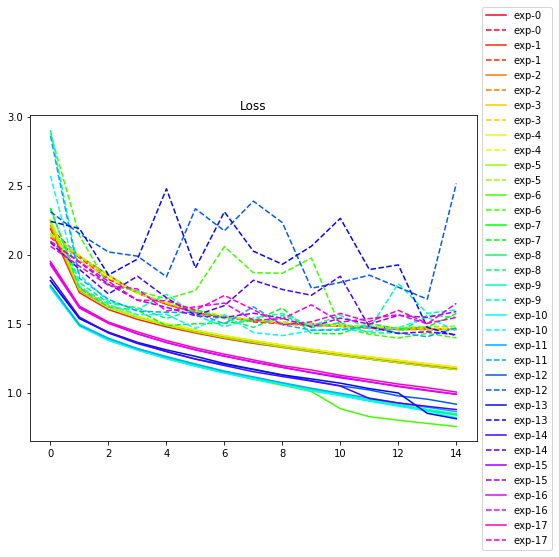

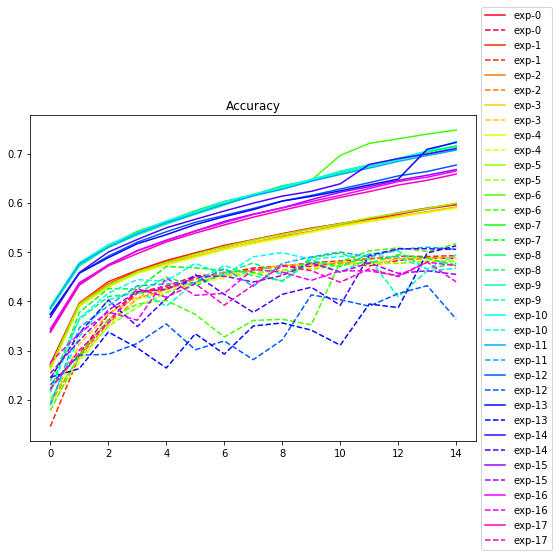

In [11]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
NUM_COLORS = len(results.keys())

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()